# 2nd Assignment - (Unsupervised Learning - Clustering)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from keras.datasets import fashion_mnist
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import time
import seaborn as sns

In [2]:
# 1) Import Fashion Mnist Dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [3]:
# Check data shapes
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

## Visualize Data

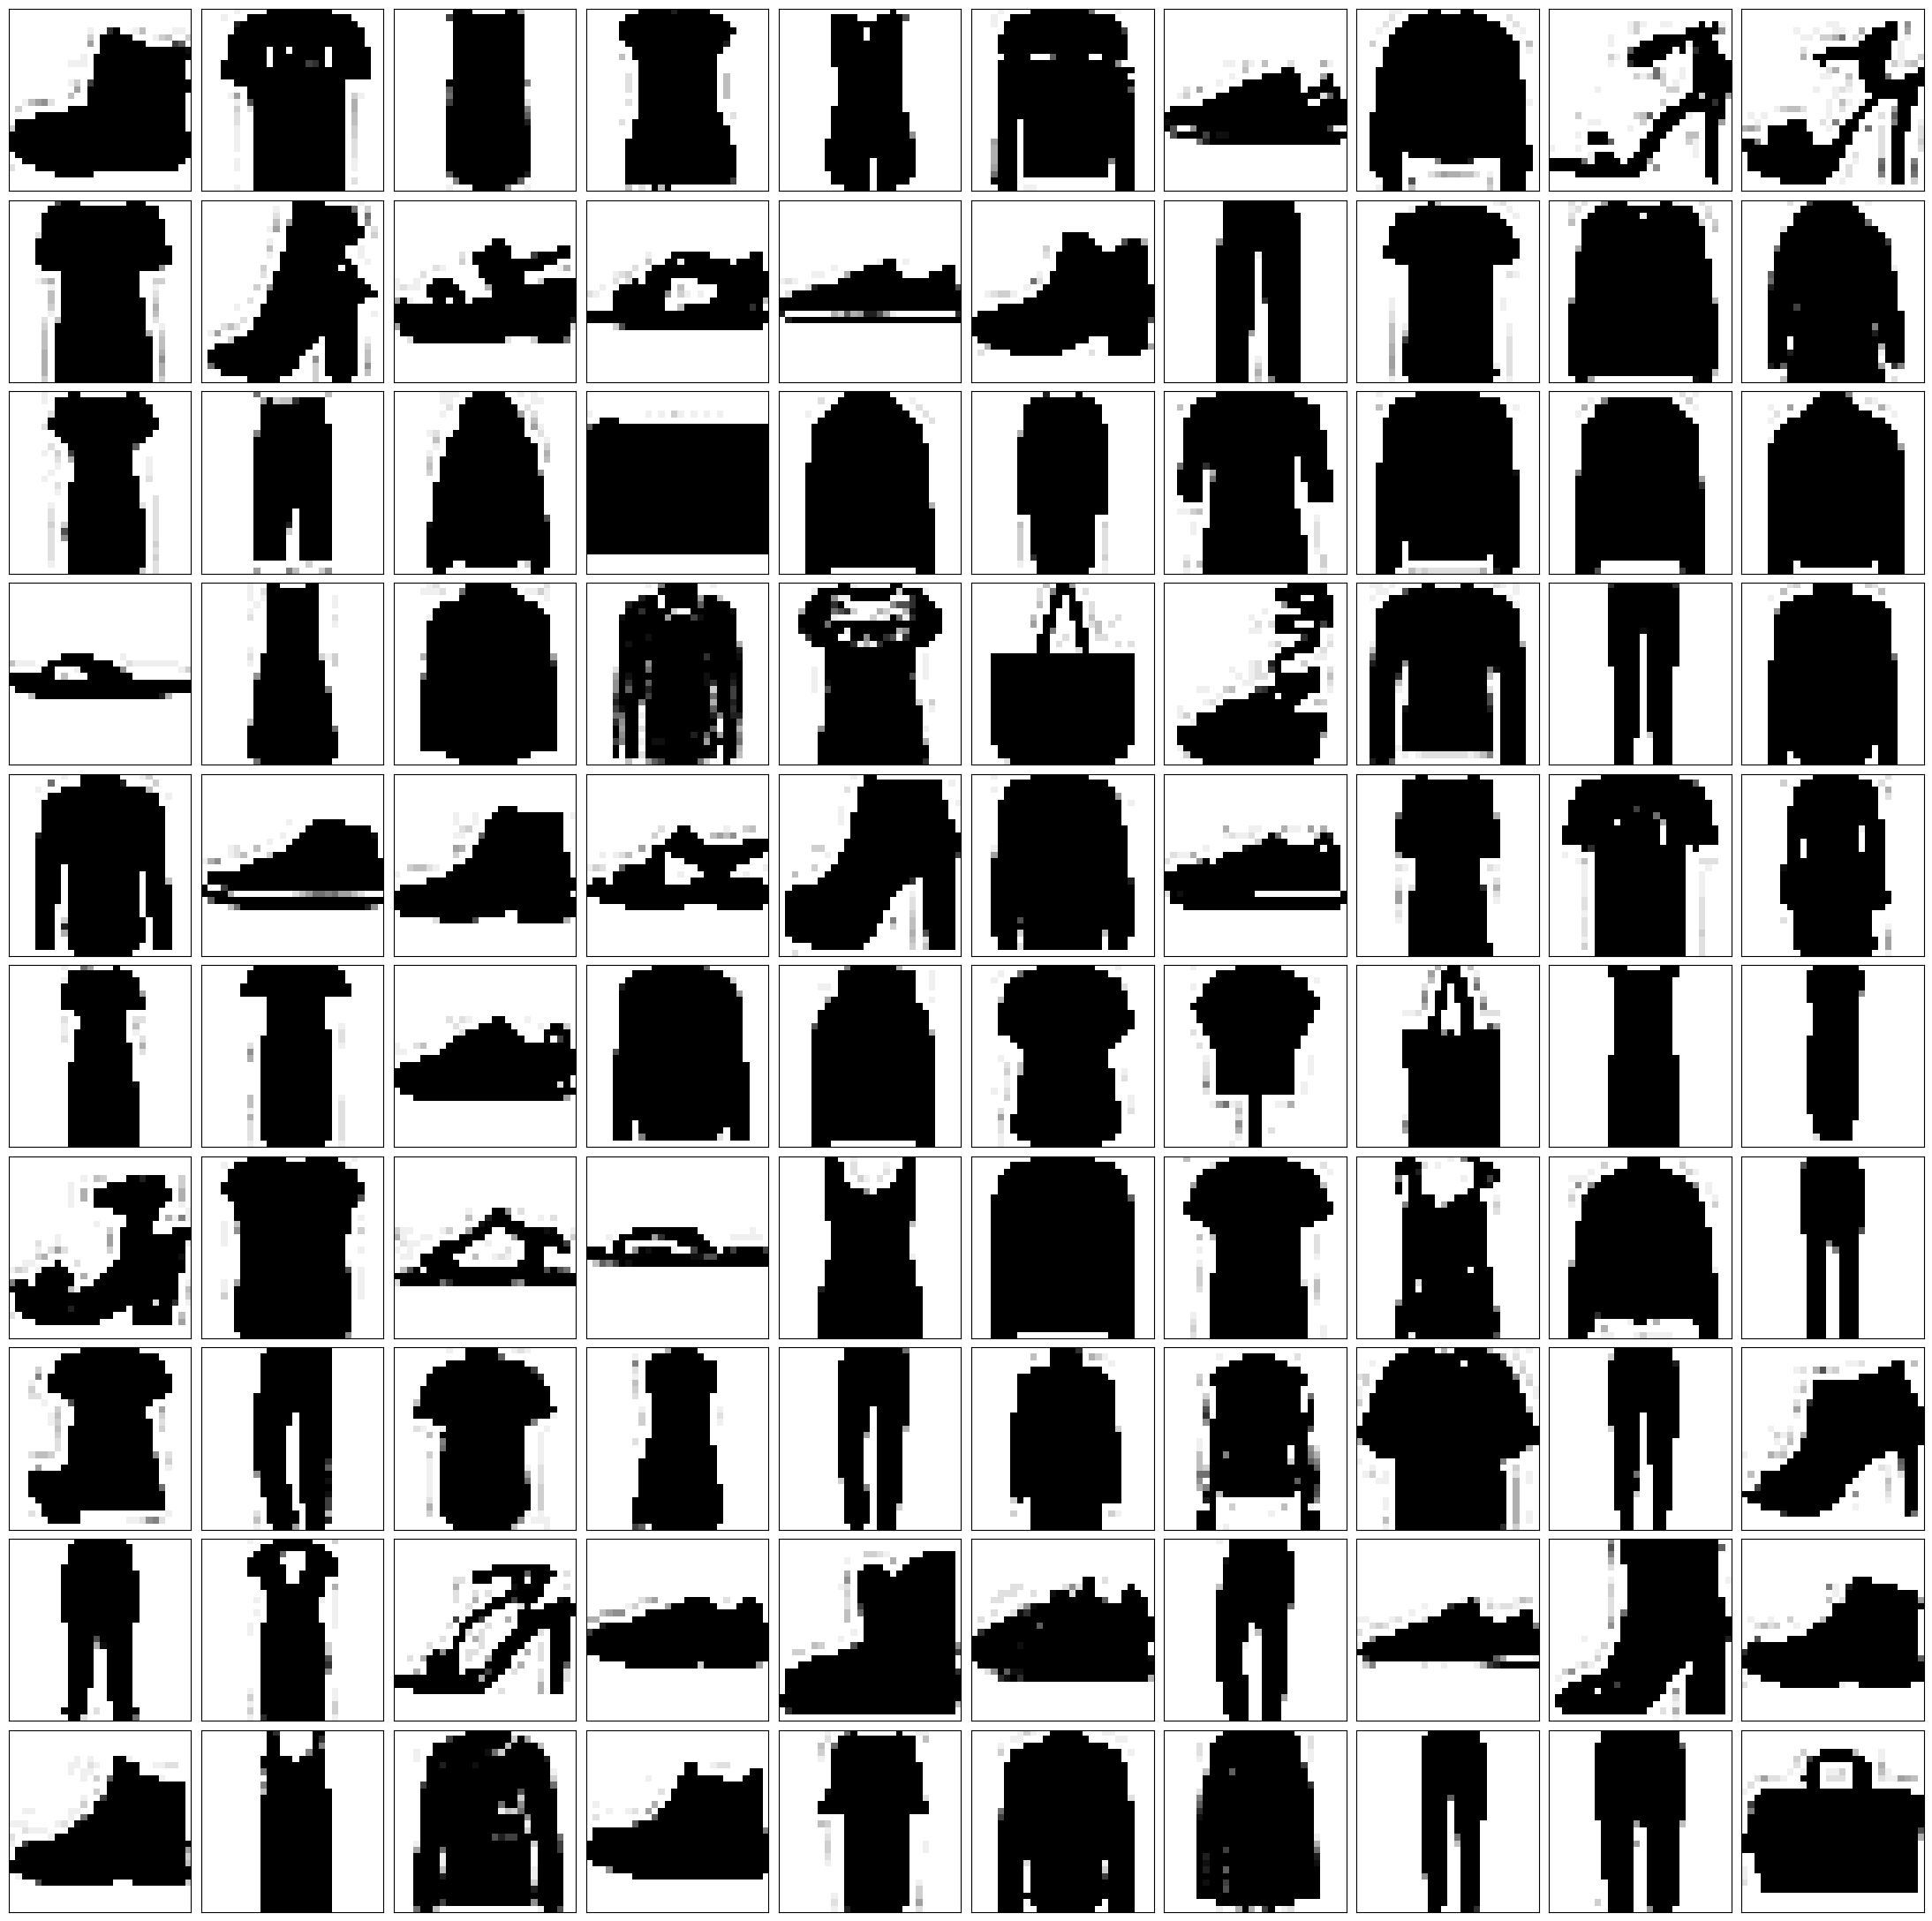

In [4]:
# Plot a grid of grayscale digit images
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(28, 28),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i], cmap='binary')
        im.set_clim(0, 16)
plot_digits(X_train)

## Preprocess Data

In [5]:
# Normalize data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape Data
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 2) Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## Dimensionality Reduction Functions

In [6]:
# 3, 6) Principal Component Analysis (PCA)
def apply_pca(X_train, X_val, X_test, n_components=50):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_val_pca, X_test_pca, pca

# 3, 6) Stacked Autoencoder (SAE)
def build_autoencoder(input_dim, encoding_dim):
    input_img = Input(shape=(input_dim,))
    encoded = Dense(256, activation='relu')(input_img)
    encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoded)

    decoded = Dense(256, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder, encoder

def apply_sae(X_train, X_val, X_test, encoding_dim=50, epochs=50, batch_size=128):
    input_dim = X_train.shape[1]
    autoencoder, encoder = build_autoencoder(input_dim, encoding_dim)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = autoencoder.fit(X_train, X_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              shuffle=True,
                              validation_data=(X_val, X_val),
                              callbacks=[early_stopping])
    X_train_sae = encoder.predict(X_train)
    X_val_sae = encoder.predict(X_val)
    X_test_sae = encoder.predict(X_test)
    return X_train_sae, X_val_sae, X_test_sae, autoencoder, encoder, history

## Clustering Funcions and Metrics

In [7]:
# 7)
def apply_clustering(algorithm, X):
    if algorithm == 'MiniBatchKMeans':
      clustering = MiniBatchKMeans(n_clusters=10, random_state=42, n_init=3)
    elif algorithm == 'GMM':
      clustering = GaussianMixture(n_components=10, random_state=42)
    else:
      raise ValueError("Unknown algorithm: " + algorithm)
    start_time = time.time()
    y_pred = clustering.fit_predict(X)
    end_time = time.time()
    execution_time = end_time - start_time
    return y_pred, execution_time

# 8. Calculate Metrics
def calculate_metrics(X, y_pred):
    ch_score = calinski_harabasz_score(X, y_pred)
    db_score = davies_bouldin_score(X, y_pred)
    silhouette_avg = silhouette_score(X, y_pred)
    return ch_score, db_score, silhouette_avg

In [8]:
# 9. Dataframe for storing results
results = pd.DataFrame(columns=['Dimensionality Reduction', 'Clustering Algorithm', 'Training Time', 'Execution Time', 'Clusters', 'Calinski-Harabasz Index', 'Davies-Bouldin Index', 'Silhouette Score'])

## Apply Clustering to Raw, PCA, SAE Data

In [9]:
# Raw Data
for algorithm in ['MiniBatchKMeans', 'GMM']:
    y_pred, execution_time = apply_clustering(algorithm, X_test)
    ch_score, db_score, silhouette_avg = calculate_metrics(X_test, y_pred)
    new_row = pd.DataFrame([{
        'Dimensionality Reduction': 'Raw',
        'Clustering Algorithm': algorithm,
        'Training Time': 0,
        'Execution Time': execution_time,
        'Clusters': len(np.unique(y_pred)),
        'Calinski-Harabasz Index': ch_score,
        'Davies-Bouldin Index': db_score,
        'Silhouette Score': silhouette_avg
    }])
    results = pd.concat([results, new_row], ignore_index=True)

In [10]:
# PCA
start_time = time.time()
X_train_pca, X_val_pca, X_test_pca, pca = apply_pca(X_train, X_val, X_test)
end_time = time.time()
pca_training_time = end_time - start_time

for algorithm in ['MiniBatchKMeans', 'GMM']:
    y_pred, execution_time = apply_clustering(algorithm, X_test_pca)
    ch_score, db_score, silhouette_avg = calculate_metrics(X_test_pca, y_pred)
    new_row = pd.DataFrame([{
        'Dimensionality Reduction': 'PCA',
        'Clustering Algorithm': algorithm,
        'Training Time': pca_training_time,
        'Execution Time': execution_time,
        'Clusters': len(np.unique(y_pred)),
        'Calinski-Harabasz Index': ch_score,
        'Davies-Bouldin Index': db_score,
        'Silhouette Score': silhouette_avg
    }])
    results = pd.concat([results, new_row], ignore_index=True)

In [11]:
# SAE
start_time = time.time()
X_train_sae, X_val_sae, X_test_sae, autoencoder, encoder, autoencoder_history = apply_sae(X_train, X_val, X_test)
end_time = time.time()
sae_training_time = end_time - start_time

for algorithm in ['MiniBatchKMeans', 'GMM']:
    y_pred, execution_time = apply_clustering(algorithm, X_test_sae)
    ch_score, db_score, silhouette_avg = calculate_metrics(X_test_sae, y_pred)
    new_row = pd.DataFrame([{
        'Dimensionality Reduction': 'SAE',
        'Clustering Algorithm': algorithm,
        'Training Time': sae_training_time,
        'Execution Time': execution_time,
        'Clusters': len(np.unique(y_pred)),
        'Calinski-Harabasz Index': ch_score,
        'Davies-Bouldin Index': db_score,
        'Silhouette Score': silhouette_avg
    }])
    results = pd.concat([results, new_row], ignore_index=True)

Epoch 1/50
422/422 [==============================] - 5s 6ms/step - loss: 0.3367 - val_loss: 0.3012
Epoch 2/50
422/422 [==============================] - 2s 5ms/step - loss: 0.2946 - val_loss: 0.2917
Epoch 3/50
422/422 [==============================] - 2s 4ms/step - loss: 0.2877 - val_loss: 0.2862
Epoch 4/50
422/422 [==============================] - 2s 4ms/step - loss: 0.2840 - val_loss: 0.2833
Epoch 5/50
422/422 [==============================] - 2s 4ms/step - loss: 0.2814 - val_loss: 0.2812
Epoch 6/50
422/422 [==============================] - 2s 4ms/step - loss: 0.2796 - val_loss: 0.2797
Epoch 7/50
422/422 [==============================] - 2s 4ms/step - loss: 0.2781 - val_loss: 0.2783
Epoch 8/50
422/422 [==============================] - 3s 6ms/step - loss: 0.2769 - val_loss: 0.2771
Epoch 9/50
422/422 [==============================] - 2s 5ms/step - loss: 0.2759 - val_loss: 0.2766
Epoch 10/50
422/422 [==============================] - 2s 4ms/step - loss: 0.2750 - val_loss: 0.2758

## PCA Visualization

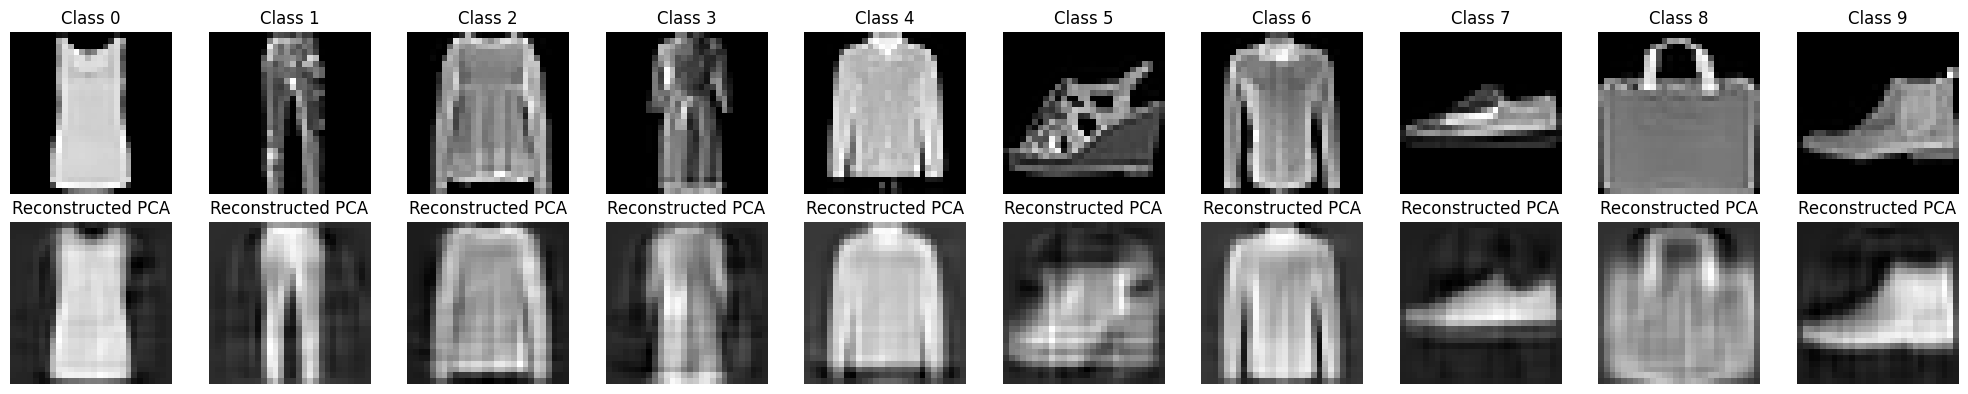

In [12]:
# 4)
# Randomly select one image from each class
classes = np.unique(y_train)
num_classes = len(classes)
random_indices = [np.random.choice(np.where(y_train == c)[0]) for c in classes]

# Initialize PCA with 50 principal components
X_train_reconstructed_pca = pca.inverse_transform(X_train_pca)

# Display random images and their reconstructions
fig, axes = plt.subplots(2, num_classes, figsize=(2*num_classes, 4))

for i, idx in enumerate(random_indices):
    # Original image
    axes[0, i].imshow(X_train[idx].reshape(28, 28), cmap='gray')
    axes[0, i].set_title(f'Class {y_train[idx]}')
    axes[0, i].axis('off')

    # PCA-reconstructed image
    axes[1, i].imshow(X_train_reconstructed_pca[idx].reshape(28, 28), cmap='gray')
    axes[1, i].set_title(f'Reconstructed PCA')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Shape of X_train_pca: (54000, 50)
Shape of X_test_pca: (10000, 50)


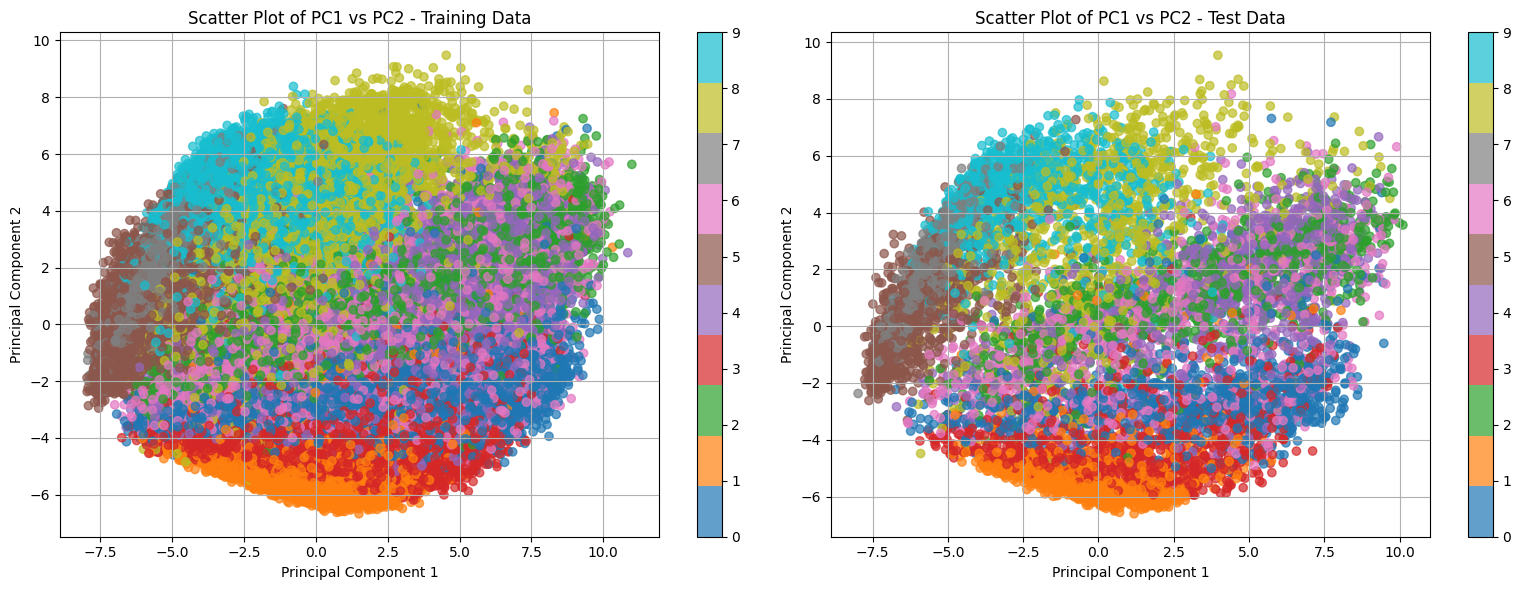

In [13]:
# 5) Scatter plot of the first two principal components colored by classes.
# Print shapes of X_train_pca and X_test_pca
print("Shape of X_train_pca:", X_train_pca.shape)
print("Shape of X_test_pca:", X_test_pca.shape)

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot for X_train_pca
scatter_train = ax1.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='tab10', alpha=0.7)
ax1.set_title('Scatter Plot of PC1 vs PC2 - Training Data')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
fig.colorbar(scatter_train, ax=ax1)
ax1.grid(True)

# Plot for X_test_pca
scatter_test = ax2.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='tab10', alpha=0.7)
ax2.set_title('Scatter Plot of PC1 vs PC2 - Test Data')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
fig.colorbar(scatter_test, ax=ax2)
ax2.grid(True)

# Adjust layout and display plots
plt.tight_layout()
plt.show()

# Stacked Autoencoder (SAE) Visualization

1688/1688 [==============================] - 3s 2ms/step


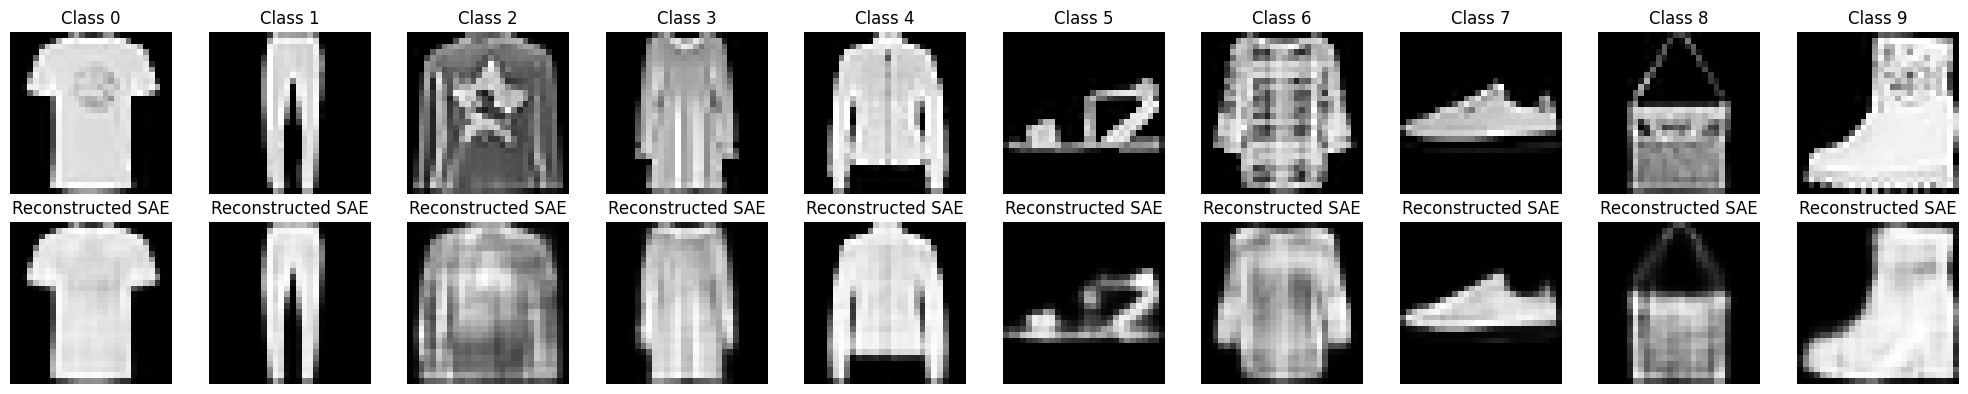

In [14]:
# 4)
# Reconstruct images using SAE (Stacked Autoencoder)
X_train_reconstructed_sae = autoencoder.predict(X_train)

# Randomly select one image from each class
random_indices = [np.random.choice(np.where(y_train == c)[0]) for c in classes]

# Display random images and their reconstructions
fig, axes = plt.subplots(2, num_classes, figsize=(2*num_classes, 4))

for i, idx in enumerate(random_indices):
    # Original image
    axes[0, i].imshow(X_train[idx].reshape(28, 28), cmap='gray')
    axes[0, i].set_title(f'Class {y_train[idx]}')
    axes[0, i].axis('off')

    # SAE-reconstructed image
    axes[1, i].imshow(X_train_reconstructed_sae[idx].reshape(28, 28), cmap='gray')
    axes[1, i].set_title(f'Reconstructed SAE')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

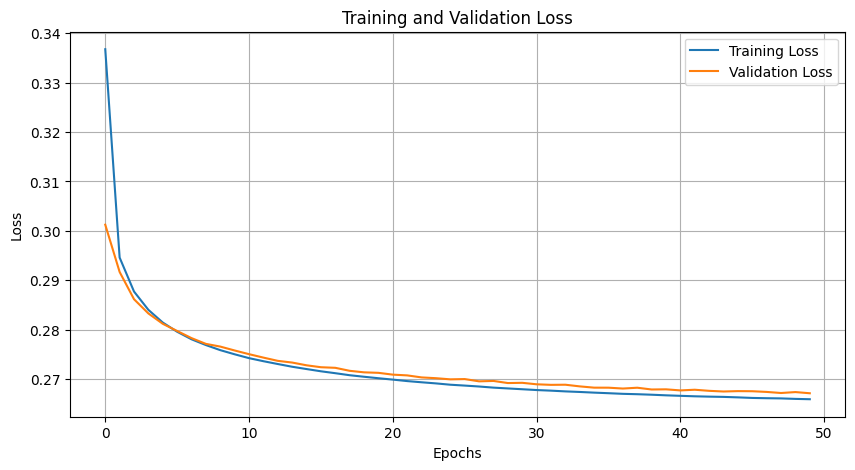

In [15]:
# 5) Visualize training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(autoencoder_history.history['loss'], label='Training Loss')
plt.plot(autoencoder_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Shape of train encoded data: (54000, 50)
Shape of test encoded data: (10000, 50)


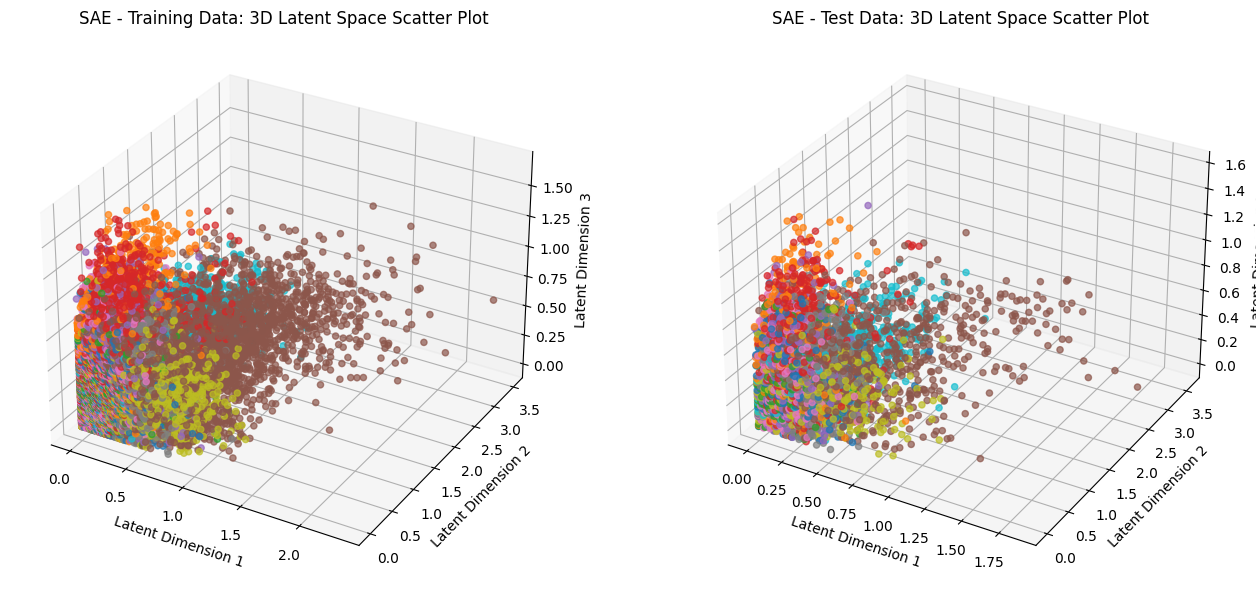

In [16]:
# 5)
# Check the shape of the encoded data
print("Shape of train encoded data:", X_train_sae.shape)
print("Shape of test encoded data:", X_test_sae.shape)

X_train_sae_3d = X_train_sae[:, :3]
X_test_sae_3d = X_test_sae[:, :3]

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(14, 6))

# 3D scatter plot for X_train_sae_3d
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X_train_sae_3d[:, 0], X_train_sae_3d[:, 1], X_train_sae_3d[:, 2], c=y_train, cmap='tab10', alpha=0.7)
ax1.set_title('SAE - Training Data: 3D Latent Space Scatter Plot')
ax1.set_xlabel('Latent Dimension 1')
ax1.set_ylabel('Latent Dimension 2')
ax1.set_zlabel('Latent Dimension 3')

# 3D scatter plot for X_test_sae_3d
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_test_sae_3d[:, 0], X_test_sae_3d[:, 1], X_test_sae_3d[:, 2], c=y_test, cmap='tab10', alpha=0.7)
ax2.set_title('SAE - Test Data: 3D Latent Space Scatter Plot')
ax2.set_xlabel('Latent Dimension 1')
ax2.set_ylabel('Latent Dimension 2')
ax2.set_zlabel('Latent Dimension 3')

plt.tight_layout()
plt.show()

## Results - Best Clustering Technique

In [17]:
# Print Results
print(results)

# Define the CSV file path
csv_file = "clustering_results.csv"

# Save results to CSV file
results.to_csv(csv_file, index=False)

  Dimensionality Reduction Clustering Algorithm Training Time  Execution Time  \
0                      Raw      MiniBatchKMeans             0        2.050259   
1                      Raw                  GMM             0      159.740287   
2                      PCA      MiniBatchKMeans      3.464997        0.396194   
3                      PCA                  GMM      3.464997        4.257926   
4                      SAE      MiniBatchKMeans    150.171638        0.174686   
5                      SAE                  GMM    150.171638        5.969341   

  Clusters  Calinski-Harabasz Index  Davies-Bouldin Index  Silhouette Score  
0       10              1183.382937              2.134079          0.123747  
1       10              1029.288628              2.192798          0.105612  
2       10              1677.350128              1.814430          0.182220  
3       10              1094.198595              2.580962          0.127124  
4       10               996.805174       

Best Clustering: Dimensionality Reduction                PCA
Clustering Algorithm        MiniBatchKMeans
Training Time                      3.464997
Execution Time                     0.396194
Clusters                                 10
Calinski-Harabasz Index         1677.350128
Davies-Bouldin Index                1.81443
Silhouette Score                    0.18222
Name: 2, dtype: object


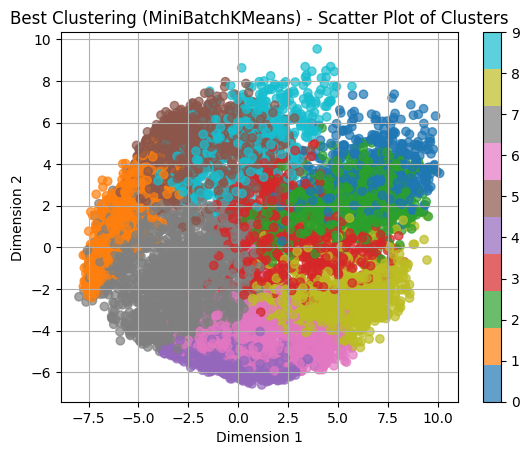

In [18]:
# 10. Visualization of the best clustering

best_clustering = results.loc[results['Silhouette Score'].idxmax()]
print("Best Clustering:", best_clustering)

best_algorithm = best_clustering['Clustering Algorithm']
if best_clustering['Dimensionality Reduction'] == 'PCA':
    X_best = X_test_pca
elif best_clustering['Dimensionality Reduction'] == 'SAE':
    X_best = X_test_sae
else:
    X_best = X_test

y_pred, _ = apply_clustering(best_algorithm, X_best)

# Scatter plot colored by clusters
scatter = plt.scatter(X_best[:, 0], X_best[:, 1], c=y_pred, cmap='tab10', alpha=0.7)
plt.title(f'Best Clustering ({best_algorithm}) - Scatter Plot of Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar(scatter)
plt.grid(True)
plt.show()

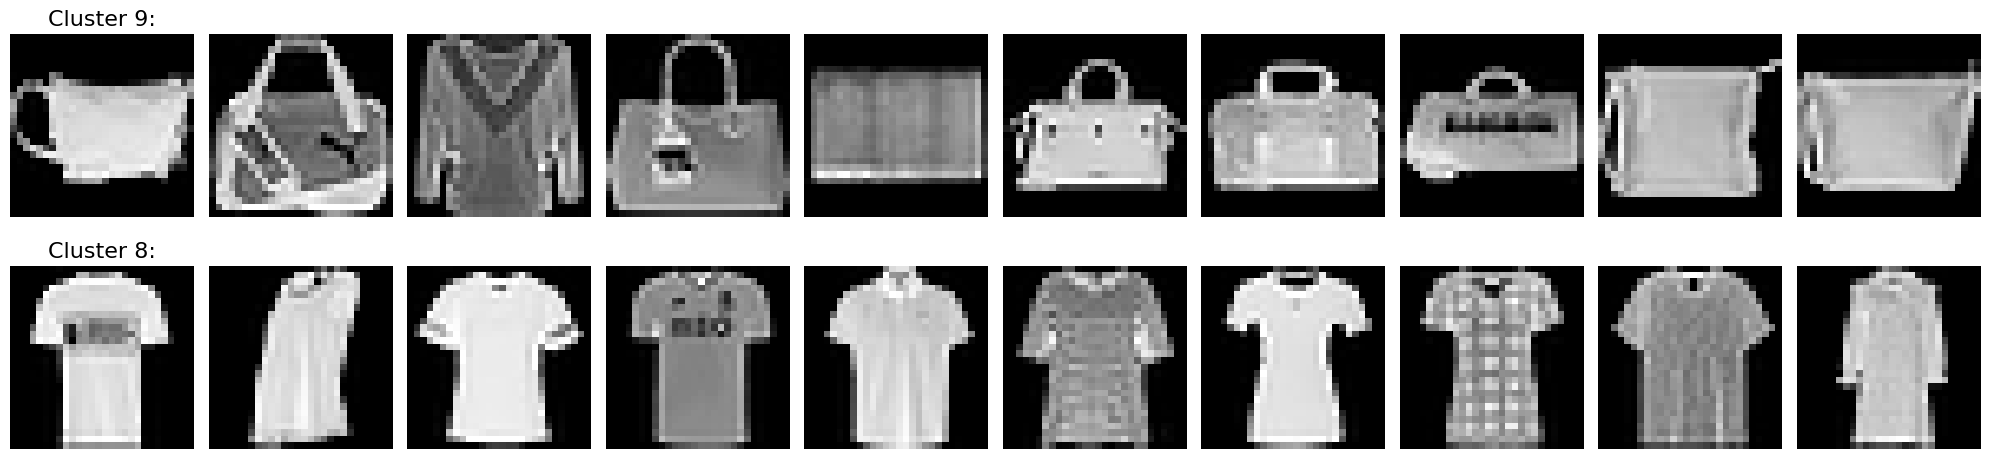

In [19]:
# Visualization of random images from two clusters
clusters = np.unique(y_pred)
selected_clusters = np.random.choice(clusters, 2, replace=False)

fig, axes = plt.subplots(2, 10, figsize=(20, 5))
for i, cluster in enumerate(selected_clusters):
    cluster_indices = np.where(y_pred == cluster)[0]
    selected_indices = np.random.choice(cluster_indices, 10, replace=False)
    for j, idx in enumerate(selected_indices):
        axes[i, j].imshow(X_test[idx].reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(f'Cluster {cluster}:', fontsize=16)

plt.tight_layout()
plt.show()

## Comparing Clustering Performances'

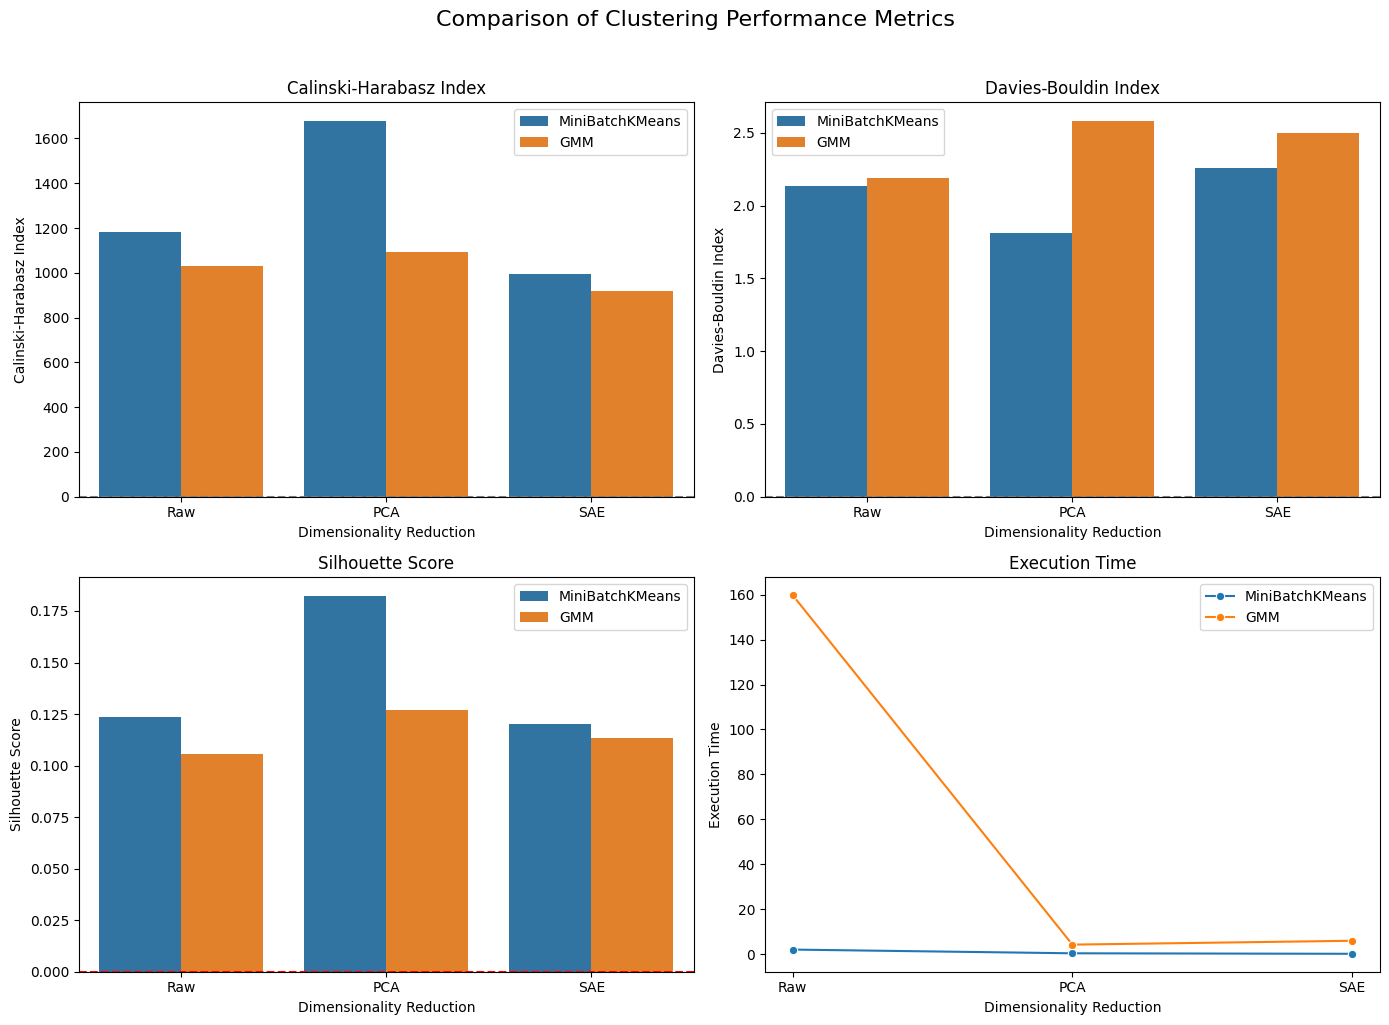

In [20]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Calinski-Harabasz Index
sns.barplot(data=results, x='Dimensionality Reduction', y='Calinski-Harabasz Index', hue='Clustering Algorithm', ax=axes[0, 0])
axes[0, 0].set_title('Calinski-Harabasz Index')
axes[0, 0].set_xlabel('Dimensionality Reduction')
axes[0, 0].set_ylabel('Calinski-Harabasz Index')
axes[0, 0].axhline(0, ls='--', color='grey')
axes[0, 0].legend()

# Davies-Bouldin Index
sns.barplot(data=results, x='Dimensionality Reduction', y='Davies-Bouldin Index', hue='Clustering Algorithm', ax=axes[0, 1])
axes[0, 1].set_title('Davies-Bouldin Index')
axes[0, 1].set_xlabel('Dimensionality Reduction')
axes[0, 1].set_ylabel('Davies-Bouldin Index')
axes[0, 1].axhline(0, ls='--', color='grey')
axes[0, 1].legend()

# Silhouette Score
sns.barplot(data=results, x='Dimensionality Reduction', y='Silhouette Score', hue='Clustering Algorithm', ax=axes[1, 0])
axes[1, 0].set_title('Silhouette Score')
axes[1, 0].set_xlabel('Dimensionality Reduction')
axes[1, 0].set_ylabel('Silhouette Score')
axes[1, 0].axhline(0, ls='--', color='red')  # Adding a dashed line at y=0 to indicate the boundary
axes[1, 0].legend()

# Execution Time
sns.lineplot(data=results, x='Dimensionality Reduction', y='Execution Time', hue='Clustering Algorithm', marker='o', ax=axes[1, 1])
axes[1, 1].set_title('Execution Time')
axes[1, 1].set_xlabel('Dimensionality Reduction')
axes[1, 1].set_ylabel('Execution Time')
axes[1, 1].legend()

fig.suptitle('Comparison of Clustering Performance Metrics', fontsize=16, y=1.02)

# Adjust layout
plt.tight_layout()
plt.show()